In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')
# data_dir = Path('C:/Users/Kian/Documents/data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf=64
psf_pixelscale_mas = 21.82142167566928*u.mas/u.pix
psf_pixelscale_lamD = psf_pixelscale_mas.value / mas_per_lamD.value
psf_pixelscale = 13e-6 * psf_pixelscale_lamD/(1/2)
psf_pixelscale_m = psf_pixelscale*u.m/u.pix

iwa = 2.8
owa = 9.7

In [2]:
import proper
import roman_phasec_proper
proper.__version__, roman_phasec_proper.__version__

('3.2.5', '1.2.8')

# Load PSFs

In [2]:
psfs_fpath = data_dir/'psfs'/'hlc_band1_psfs_20230221.fits'

psfs = fits.getdata(psfs_fpath)
print(psfs.shape, len(psfs))
fits.getheader(psfs_fpath)

(3601, 64, 64) 3601


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   64                                                  
NAXIS2  =                   64                                                  
NAXIS3  =                 3601                                                  
PXSCLAMD=   0.4347826086956522 / pixel scale in lam0/D per pixel                
PXSCLMAS=    21.82142167566928 / pixel scale in mas per pixel                   
PIXELSCL=              1.3E-05 / pixel scale in meters per pixel                
CWAVELEN=             5.75E-07 / central wavelength in meters                   
BANDPASS=                  0.1 / bandpass as fraction of CWAVELEN               
POLAXIS =                   10 / polaxis: defined by roman_phasec_proper        

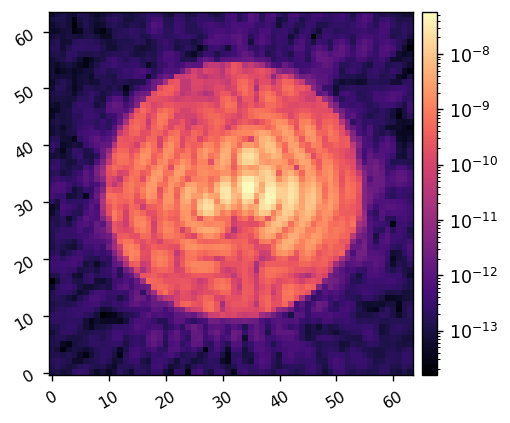

In [4]:
for psf in psfs:
    try:
        misc.myimshow(psf, lognorm=True)
        clear_output(wait=True)
        time.sleep(0.5)
    except KeyboardInterrupt:
        break

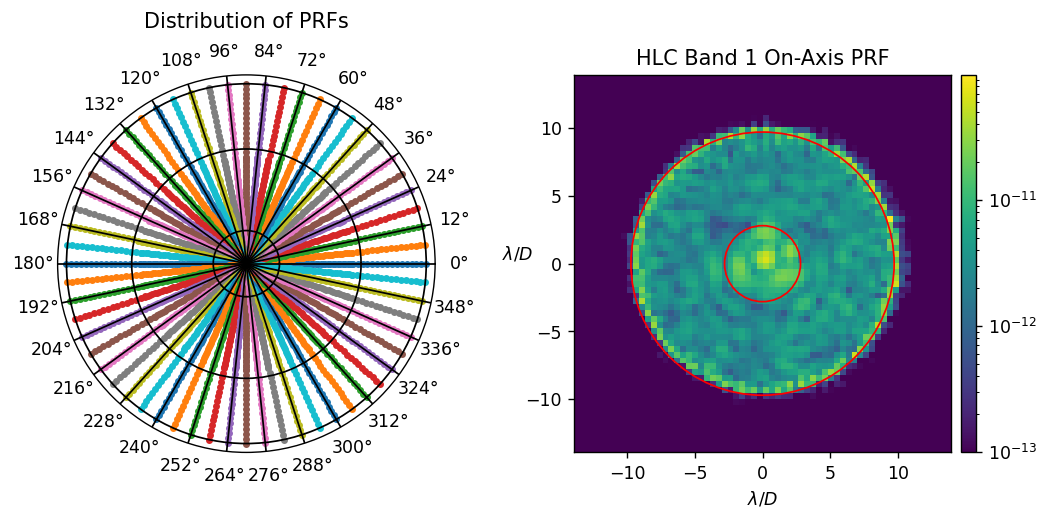

In [20]:
r_offsets_fpath = data_dir/'psfs'/'hlc_band1_psfs_radial_samples_20230221.fits'
thetas_fpath = data_dir/'psfs'/'hlc_band1_psfs_theta_samples_20230221.fits'

r_offsets = fits.getdata(r_offsets_fpath)
thetas = fits.getdata(thetas_fpath)*u.degree

# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig = plt.figure(dpi=125, figsize=(10,4))

ax1 = plt.subplot(121, projection='polar')
ax1.plot(theta_offsets, r_offsets[1:], '.', )
ax1.set_yticklabels([])
ax1.set_rticks([iwa, owa, max(r_offsets)], color='r')  # Less radial ticks
ax1.set_rlabel_position(55)  # Move radial labels away from plotted line
ax1.set_thetagrids(thetas[::2].value)
ax1.grid(axis='x', visible=True, color='black', linewidth=1)
ax1.grid(axis='y', color='black', linewidth = 1)
ax1.set_title('Distribution of PRFs', va='bottom')
ax1.set_axisbelow(False)

ax2 = plt.subplot(122)
ext = [-psf_pixelscale_lamD*npsf/2, psf_pixelscale_lamD*npsf/2,
       -psf_pixelscale_lamD*npsf/2, psf_pixelscale_lamD*npsf/2]
im = ax2.imshow(psfs[0], norm=LogNorm(vmin=psfs[0].max()/1e3), cmap='viridis', extent=ext)
ax2.add_patch(Circle((0, 0), iwa, color='r', fill=False))
ax2.add_patch(Circle((0, 0), owa, color='r', fill=False))
ax2.set_title('HLC Band 1 On-Axis PRF')
ax2.set_xlabel('$\lambda/D$')
ax2.set_ylabel('$\lambda/D$', rotation=0)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.075)
fig.colorbar(im, cax=cax)

In [5]:
r_offsets, thetas

(array([ 0.        ,  0.20721561,  0.41443121,  0.62164682,  0.82886243,
         1.03607803,  1.24329364,  1.45050925,  1.65772485,  1.86494046,
         2.07215607,  2.27937167,  2.48658728,  2.69380289,  2.90101849,
         3.1082341 ,  3.31544971,  3.52266531,  3.72988092,  3.93709653,
         4.        ,  4.20721561,  4.41443121,  4.62164682,  4.82886243,
         5.03607803,  5.24329364,  5.45050925,  5.65772485,  5.86494046,
         6.07215607,  6.27937167,  6.48658728,  6.69380289,  6.90101849,
         7.1082341 ,  7.31544971,  7.52266531,  7.72988092,  7.93709653,
         8.14431213,  8.35152774,  8.55874335,  8.76595895,  8.97317456,
         9.        ,  9.41443121,  9.82886243, 10.24329364, 10.65772485,
        11.07215607, 11.48658728, 11.90101849, 12.31544971, 12.72988092,
        13.14431213, 13.55874335, 13.97317456, 14.38760577, 14.80203699,
        15.2164682 ]),
 <Quantity [  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,
             60.,  66.,  72.,

# Setup/Test the interpolating function

In [6]:
r_offsets_mas = r_offsets * mas_per_lamD

# def find_closest_psf(xoff, yoff, verbose=True):
#     r = np.sqrt(xoff**2+yoff**2)
#     theta = np.arctan2(yoff,xoff).to(u.deg)
#     if theta<0: theta += 360*u.deg
        
#     kr = np.argmin(np.abs(r_offsets_mas-r))
#     if kr>(len(r_offsets)-1):
#         kr = len(r_offsets)-1
#     kth = np.argmin(np.abs(thetas-theta))
#     theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
#     if kr==0: 
#         kpsf=0
#     else: 
#         kpsf = 1 + kth + (len(thetas))*(kr-1)
    
#     if verbose: 
#         print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
#         print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
#         print('PSF index = {:d}'.format(kpsf))
    
#     closest_psf = psfs[kpsf]
#     interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=5)
    
#     return interpped_psf

def find_closest_psf(xoff, yoff, verbose=True):
    r = np.sqrt(xoff**2+yoff**2)
    theta = np.arctan2(yoff,xoff).to(u.deg)
    if theta<0: theta += 360*u.deg
        
    kr = np.argmin(np.abs(r_offsets_mas-r))
    kth = np.argmin(np.abs(thetas-theta))
    theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
    if kr==0: kpsf=0
    else: 
        kpsf = 1 + kth + (len(thetas))*(kr-1)
    
    if verbose: 
        print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
        print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
        print('PSF index = {:d}'.format(kpsf))
    
    closest_psf = psfs[kpsf]
    interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=1)
    
    return interpped_psf

In [44]:
20.8*(5*npsf//7 - npsf//2)

270.40000000000003

Desired r=270.00 mas, radial index=27, closest available r=273.56 mas
Desired th=100.00 deg, theta index=17, closest available th=102.00 deg, difference=-2.00 deg
PSF index = 1578


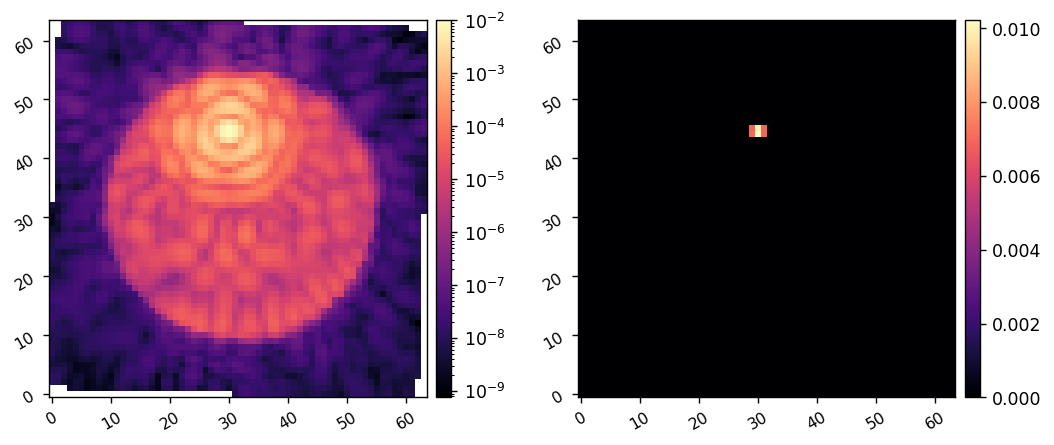

0.048084011501703425

In [7]:
r = 270*u.mas
th = 100*u.deg
xoff = r*np.cos(th)
yoff = r*np.sin(th)
psf = find_closest_psf(xoff,yoff)

mask = (psf>psf.max()/2)

misc.myimshow2(psf, mask*psf, lognorm1=True)
np.sum(mask*psf)

# Create the grid for which the interpolated PSFs will be calculated

In [8]:
ndisk = 64
disk_pixelscale_mas = 21.84*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix
x

<Quantity [-687.96, -666.12, -644.28, ...,  644.28,  666.12,  687.96] mas>

Desired r=972.92 mas, radial index=60, closest available r=763.70 mas
Desired th=225.00 deg, theta index=37, closest available th=222.00 deg, difference=3.00 deg
PSF index = 3578


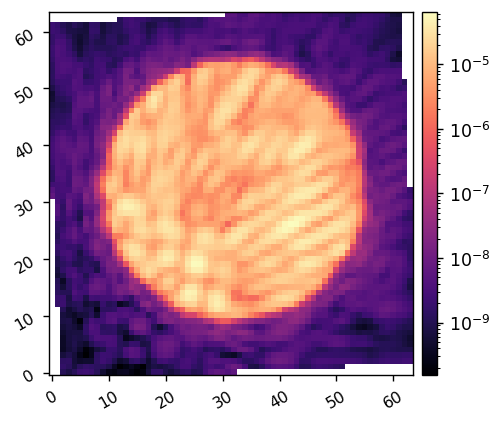

In [9]:
xoff = x[0]
yoff = y[0]
psf = find_closest_psf(xoff,yoff)

misc.myimshow(psf, lognorm=True)

In [10]:
ncols = ndisk**2
ipsf_matrix = np.zeros((npsf**2, ncols))

start=time.time()
for i in range(ncols):
    ipsf = find_closest_psf(x[i], y[i], verbose=False)
    ipsf_matrix[:,i] = ipsf.flatten() # assign the flattened psf to the column
    if i==ncols/8 or i==ncols/4 or i==ncols/2 or i==ncols*3/4 or i==ncols*7/8 or i==ncols-1:
        clear_output()
        print(i, time.time()-start)

4095 3.5831830501556396


In [11]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20230221.hdf5'
f = h5py.File(ipsf_fpath,'w')
f.create_dataset('ipsf_matrix', data=ipsf_matrix)
f.close()

# load and see if the matrix is correct

In [10]:
# ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20220920.hdf5'
# ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20221006.hdf5'
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20230221.hdf5'


f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

In [10]:
ipsf_matrix.shape

(4096, 4096)

In [32]:
x.shape

(4096,)

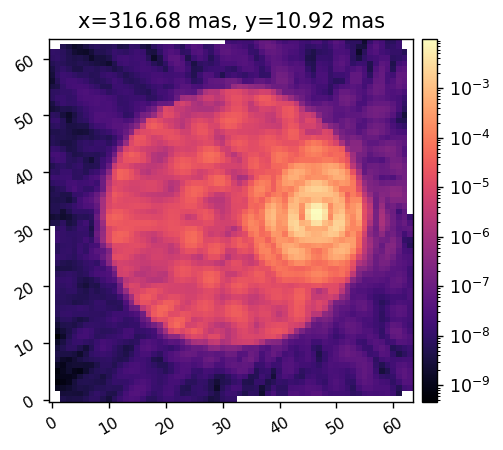

In [12]:
start = ipsf_matrix.shape[0]//2
for i in range(start, ipsf_matrix.shape[0]):
    try:
        misc.myimshow(ipsf_matrix[:,i].reshape(npsf,npsf), 'x={:.2f}, y={:.2f}'.format(x[i], y[i]), lognorm=True)
        clear_output(wait=True)
    except KeyboardInterrupt:
        break